## This notebook produces the data behind the figures in Zucker, Peek, & Loebman 2022.

We start by fetching the catalog of stellar data used in the construction of the strings from Kounkel & Covey 2019 (their Table 1). We then cross-match the Gaia DR2 data on the stellar members with updated Gaia EDR3 data. To produce this crossmatched table, we run the ADQL command given in "Kounkel_GaiaDR2_EDR3_ADQL_Query.txt". We also read in the properties of the strings (Table 2 in Kounkel & Covey 2019) and the coordinates of the stellar string spines (Table 3 in Kounkel & Covey 2019). 

In [1]:
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
import codecs
from astropy.table import Table

#fetch Table 1 from Kounkel & Covey 2019
viz = Vizier(columns=['**'],timeout=600)
viz.ROW_LIMIT = -1
table1 = viz.get_catalogs("J/AJ/158/122/table1")[0]
table1.write("Kounkel_Covey_2019_Table1.vot",overwrite=True,format='votable')

#if you want to fetch the cross-matched table from scratch, set this to true (takes a while)
#otherwise, if you've already run this cell, you can set to False and read in the existing file
download_crossmatch_table = True

if download_crossmatch_table == True:
    
    #crossmatch Gaia DR2 stellar member data with Gaia EDR3 stellar member data
    with codecs.open('Kounkel_GaiaDR2_EDR3_ADQL_Query.txt', 'r', encoding='utf-8',
                     errors='ignore') as file:
        query = file.read()

    upload_resource = "Kounkel_Covey_2019_Table1.vot"
    Gaia.ROW_LIMIT = -1 #return all rows
    print(query)
    j = Gaia.launch_job_async(query=query,upload_resource=upload_resource, upload_table_name="kounkel2019", verbose=True)

    #cross-matched Table 1, now including both DR2 and EDR3 data
    tstars = j.get_results()
    
else:
    tstars = Table.read("Kounkel2019_GaiaDR2_to_EDR3.vot")

#fetch Table 2 from Kounkel & Covey 2019, containing group and string level properties
tgroups = viz.get_catalogs("J/AJ/158/122/table2")[0]
#restrict to only groups that are classified as strings
tstrings = tgroups[tgroups['String'] == 'y']

#fetch Table 3 from Kounkel & Covey 2019, containing coordinates of string spines
tspines = viz.get_catalogs("J/AJ/158/122/table3")[0]

SELECT kounkeldr2.gaia, kounkeldr2.raj2000 as dr2_ra,kounkeldr2.dej2000 as dr2_dec, kounkeldr2.theia, dr2_neighborhood.*, dr2.parallax as dr2_parallax, dr2.parallax_error as dr2_parallax_error, dr2.pmra as dr2_pmra, dr2.pmra_error as dr2_pmra_error, dr2.pmdec as dr2_pmdec, dr2.pmdec_error as dr2_pmdec_error, edr3.ra as edr3_ra, edr3.dec as edr3_dec,edr3.parallax as edr3_parallax, edr3.parallax_error as edr3_parallax_error, edr3.pmra as edr3_pmra, edr3.pmra_error as edr3_pmra_error, edr3.pmdec as edr3_pmdec, edr3.pmdec_error as edr3_pmdec_error, dr2.radial_velocity, dr2.radial_velocity_error
FROM tap_upload.kounkel2019 AS kounkeldr2
JOIN gaiaedr3.dr2_neighbourhood AS dr2_neighborhood ON
   kounkeldr2.gaia = dr2_neighborhood.dr2_source_id
JOIN gaiadr2.gaia_source AS dr2 ON
   dr2_neighborhood.dr2_source_id = dr2.source_id
JOIN gaiaedr3.gaia_source AS edr3 ON
   dr2_neighborhood.dr3_source_id = edr3.source_id
WHERE dr2_neighborhood.angular_distance < 30
ORDER BY kounkeldr2.gaia ASC
Launch

We start by calculating the XYZ positions of string members in both DR2 and EDR3

In [2]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

#add distance info to stellar catalogs
tstars['dr2_dist'] = 1000./tstars['dr2_parallax']
tstars['edr3_dist'] = 1000./tstars['edr3_parallax'].clip(1e-12)

#compute XYZ coordinates for both DR2 and EDR3
cstar_dr2 = SkyCoord(ra = tstars['dr2_ra'].value*u.deg, dec = tstars['dr2_dec'].value*u.deg,distance=tstars['dr2_dist'].value*u.pc, frame='icrs')
cstar_edr3 = SkyCoord(ra = tstars['edr3_ra'].value*u.deg, dec = tstars['edr3_dec'].value*u.deg,distance=tstars['edr3_dist'].value*u.pc, frame='icrs')

#add DR2 XYZ positions to the table
tstars['dr2_x'] = cstar_dr2.galactic.cartesian.x
tstars['dr2_y'] = cstar_dr2.galactic.cartesian.y
tstars['dr2_z'] = cstar_dr2.galactic.cartesian.z

#add EDR3 XYZ position to the table
tstars['edr3_x'] = cstar_edr3.galactic.cartesian.x
tstars['edr3_y'] = cstar_edr3.galactic.cartesian.y
tstars['edr3_z'] = cstar_edr3.galactic.cartesian.z

Next, we write a function that calculates the minimum distance between a star and its corresponding string spine. 

In [3]:
def calculate_spatial_offset(stellar_index, tstar, tspine, release):
    
    """
    Computes the minimum offset between a single star's XYZ position 
    and the stellar string spine to which it belongs

    Parameters
    ----------
    stellar index: int
        Index of star in the Table tstar_theia
        
    tstar_theia: astropy table
        Table of all stars in a given string
    
    tspine_theia: astropy table
        Table of spine positions for a given string
    
    release: string
        Gaia release to calculate the offset for ('dr2' or 'edr3')
    """

    #calculate distance between star and every point in the spine
    xyz_offsets = np.sqrt((tstar_theia[release+'_x'][stellar_index] - tspine_theia['X'])**2 + (tstar_theia[release+'_y'][stellar_index] - tspine_theia['Y'])**2 + (tstar_theia[release+'_z'][stellar_index] - tspine_theia['Z'])**2)
    
    #find the index corresponding to the minimum distance
    argmin = np.argmin(xyz_offsets)
               
    #grab the minimum 3D spatial offset in pc between star and closest point on the spine
    min_xyz_offset =  xyz_offsets[argmin]
                          
    return min_xyz_offset

#vectorizing this function so we can compute offsets for all stars in string with one function call
v_calculate_spatial_offset = np.vectorize(calculate_spatial_offset,excluded = [1,2,3])

Leveraging this function, we will loop through the strings and calculate the median offset between the string members and the spine using both DR2 and EDR3 data on the star positions. As we do so, we will also compute the median S/N of the parallax measurements in DR2 and EDR3, and the radial velocity dispersion for the subset of stars in the string with a Gaia DR2 radial velocity detection

In [4]:
#this table will hold the "master" properties on the strings
tsummary = Table(names=('Theia', 'dr2_offset_xyz', 'dr2_parallax_SN','edr3_offset_xyz','edr3_parallax_SN','sigmaVR','N_VR'), dtype=('i4', 'f2', 'f2','f2','f2','f4','i4'), units = {'dr2_offset_xyz':u.pc, 'edr3_offset_xyz':u.pc, 'sigmaVR':u.km/u.s})

#loop through string sample and calculate new properties for each string
for string in np.unique(tspines['Theia']):
    
    #grab stars in the string
    star_mask = np.where(tstars['theia'] == string)[0]
    tstar_theia = tstars[star_mask]

    #grab spine of the string
    spine_mask = np.where(tspines['Theia'] == string)[0]
    tspine_theia = tspines[spine_mask]
    
    #compute array of 3D spatial offsets between string spine and string members
    xyz_offset_dr2 = v_calculate_spatial_offset(np.arange(0,len(star_mask)), tstar_theia, tspine_theia,'dr2')
    xyz_offset_edr3 = v_calculate_spatial_offset(np.arange(0,len(star_mask)), tstar_theia, tspine_theia,'edr3')
            
    #calculate median 3D spatial offset between string spine and string members for a given string
    avg_dr2_offset = np.ma.median(xyz_offset_dr2)
    avg_edr3_offset = np.ma.median(xyz_offset_edr3)
            
    #calculate average signal to noise of parallaxes in string
    avg_sn_dr2 = np.ma.median(tstar_theia['dr2_parallax']/tstar_theia['dr2_parallax_error'])
    avg_sn_edr3 = np.ma.median(tstar_theia['edr3_parallax']/tstar_theia['edr3_parallax_error'])  
        
    #calculate radial velocity dispersion
    sigmaVR = np.ma.std(tstar_theia['radial_velocity'])
    
    #count number of stars with radial velocity detections
    N_VR = np.sum(~tstar_theia['radial_velocity'].mask)
    
    tsummary.add_row([string,avg_dr2_offset,avg_sn_dr2,avg_edr3_offset,avg_sn_edr3,sigmaVR,N_VR])


Next we will join our derived table of properties computed above with existing properties for the strings from Kounkel & Covey 2019, including the number of stellar members ("N_") and their reported ages ("logAge")

In [5]:
tsummary['Nstars'] = tstrings['N_']

#convert logAge from Kounkel & Covey 2019 Table 2 to age in Myr
tsummary['Age'] = (10**tstrings['logAge'].value) / 10**6 
tsummary['Age'] = tsummary['Age'] * u.Myr

### Reproducing Figure 2

We reproduce Figure 2 in Zucker, Peek, & Loebman 2022, showing the average increase in the signal to noise of the parallax measurements per string (going from Gaia DR2 to Gaia EDR3) versus the average percentage the stars get closer to their respective string spines

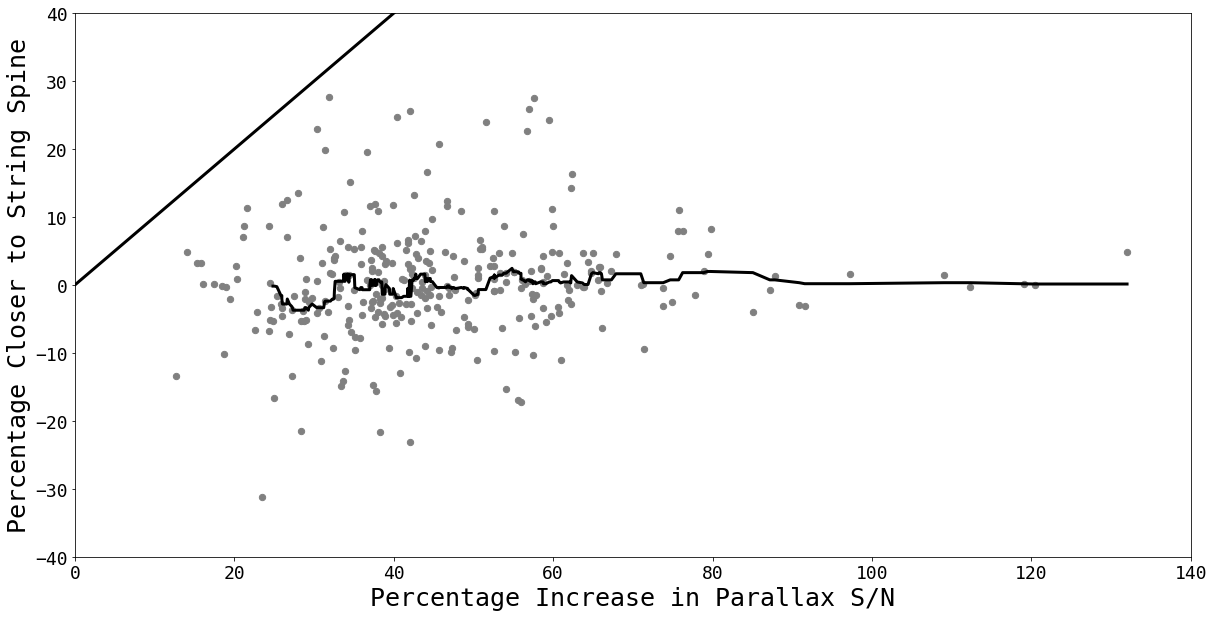

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.family"] = "monospace"

fig, ax = plt.subplots(1, figsize = (20,10))

#calculate the average increase in the S/N of the parallax measurements per string
SN_increase = 100 * ((tsummary['edr3_parallax_SN'].data - tsummary['dr2_parallax_SN'].data)/tsummary['dr2_parallax_SN'].data)

#calculate how much closer the stars get to the spine in Gaia EDR3
percent_closer = -100 * ((tsummary['edr3_offset_xyz'].data - tsummary['dr2_offset_xyz'].data)/ tsummary['dr2_offset_xyz'].data)
                  
#sort increase in S/N for purposes of computing rolling median
reorder = np.argsort(SN_increase)
SN_increase = SN_increase[reorder]
percent_closer = percent_closer[reorder]

ax.scatter(SN_increase,percent_closer,c='gray',s=40)

#compute rolling median averaging over every 25 datapoints
s = pd.Series(percent_closer)
roll_median = s.rolling(25).median()

#plot the rolling median results
plt.plot(SN_increase,roll_median,c='k',lw=3)

ax.set_xlabel("Percentage Increase in Parallax S/N",fontsize=25)
ax.set_ylabel("Percentage Closer to String Spine",fontsize=25)

ax.set_xlim(0,140)
ax.set_ylim(-40,40)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.plot(np.arange(0,45),np.arange(0,45),c='k',lw=3)

plt.savefig('Figure2.png',bbox_inches='tight',dpi=300)

Next, we will compute the predicted virial mass of the stars given their observed radial velocity dispersions:

\begin{equation}
M_{vir} = \frac{\sigma_{V_r}^{2} \times \eta \times r_{hm}}{G}
\end{equation}

where $\sigma_{V_r}$ is the observed radial velocity dispersion, $r_{hm}$ is the half-mass radius (taken to be the median distance offset between the string's 3D spine and the 3D position of its stars using Gaia EDR3 data). The parameter $\eta$ is a dimensionless constant that depends on the shape of the density profile, typically assumed to be $\eta \approx 10$ for a Plummer model characterized by steep density profiles. We very generously adopt $\eta=1$, as larger values of $\eta$ will only increase the mass required for strings to be in virial equilibrium.

In [7]:
from astropy import constants

eta = 1

#convert the Gravitational constant to same units as sigma_VR and r_hm. 
G = constants.G.to('km**2 * pc / M_sun*s**2')
tsummary['M_virial'] = (tsummary['sigmaVR'].quantity**2 * eta * tsummary['edr3_offset_xyz'].quantity) / G

print("Average Virial Mass: {:.1e} solar masses".format(np.ma.median(tsummary['M_virial'])))

Average Virial Mass: 1.8e+06 solar masses


We obtain an average predicted virial mass of around 2 million solar masses. Next, we compute the observed mass of the strings, using the number of stars per string and assigning an average mass per star of 0.61 solar masses (given the Maschberger+2013 IMF)

In [8]:
M_observed = tsummary['Nstars'] * 0.61 
tsummary['M_observed'] = M_observed*u.M_sun

tsummary['M_virial_over_observed'] = tsummary['M_virial'] / tsummary['M_observed']

print("Average Observed Mass of Strings: {:.0f}".format(np.ma.median(tsummary['M_observed'])))
print("Average Ratio of Virial to Observed Mass: {:.0f}".format(np.ma.median(tsummary['M_virial_over_observed'])))

Average Observed Mass of Strings: 134
Average Ratio of Virial to Observed Mass: 12688


We obtain an average observed mass of the strings of 134 solar masses.

Given that the predicted virial masses are orders of magnitude larger than the observed masses, all strings are gravitationally unbound. As such, we expect the string to disperse on roughly a crossing time, $\rm t_{cross}$, such that its predicted lifetime is given as:

\begin{equation}
t_{dispersal} \approx t_{cross} \approx \frac{r_{hm}}{\sigma_{V_r}}    
\end{equation}

We then take the ratio of the reported age of the string (from Kounkel & Covey 2019) to its predicted dispersal time.

In [9]:
#compute the dispersal time of the string in Myr using its estimated crossing time
t_dispersal = tsummary['edr3_offset_xyz'].quantity.to(u.km) / tsummary['sigmaVR'].quantity
tsummary['t_dispersal'] = t_dispersal.to(u.Myr)

#calculate the ratio of the strings reported age over its predicted dynamical lifetime
tsummary['age_over_dispersal'] =  tsummary['Age'] / tsummary['t_dispersal']

/Users/catherinezucker/miniconda3/envs/glue/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Reproducing Figure 3

Next, we reproduce Figure 3 in the paper, showing the ratio of the virial to observed mass (on the y-axis) versus the ratio of the reported age to the predicted age (on the x-axis).

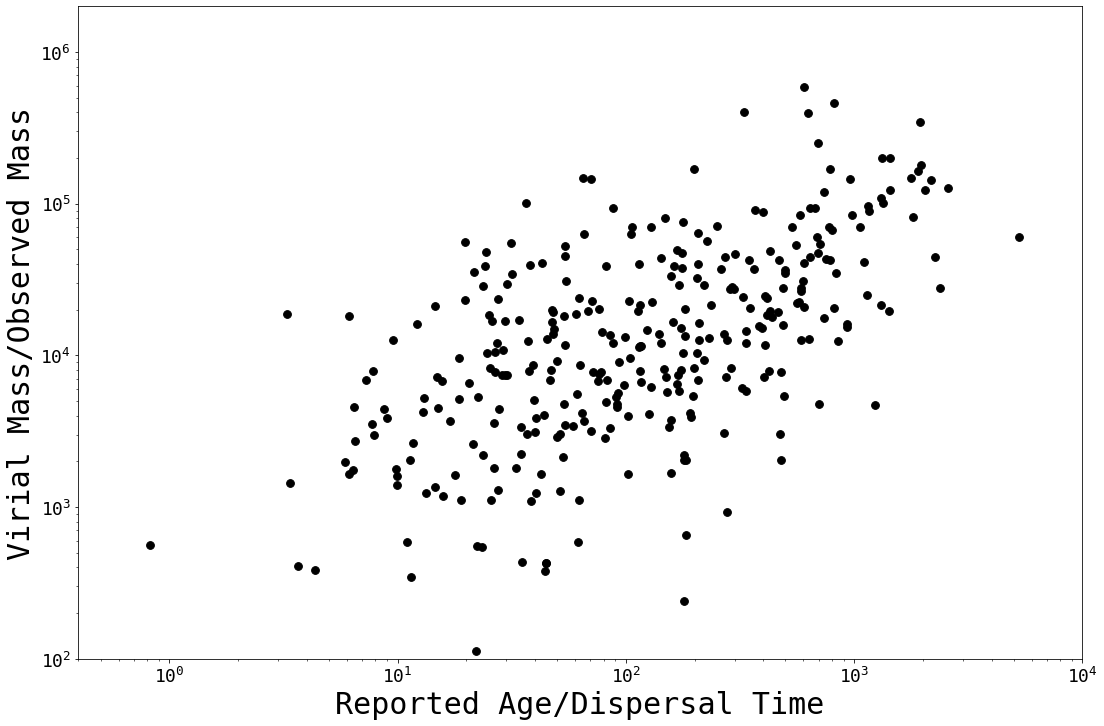

In [10]:
fig,ax = plt.subplots(1,figsize = (18,12))

ax.scatter(tsummary['age_over_dispersal'],tsummary['M_virial']/tsummary['M_observed'],s=60,c='k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(10**-0.4,10**4)
ax.set_ylim(10**2,10**6.3)

ax.set_xlabel("Reported Age/Dispersal Time",fontsize=30)
ax.set_ylabel('Virial Mass/Observed Mass',fontsize=30)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig("Figure3.png",bbox_inches='tight',dpi=300)

### Reproducing Table 1

Using the summary of string properties computed in this notebook, we write out Table 1 in the paper. 

In [11]:
#new compiled table for exporting to latex. 
tlatex = Table(masked=True)

tlatex['Theia'] = tsummary['Theia']
tlatex['DR2_offset_pc'] = tsummary['dr2_offset_xyz']
tlatex['DR2_SN'] = tsummary['dr2_parallax_SN']
tlatex['EDR3_offset_pc'] = tsummary['edr3_offset_xyz']
tlatex['EDR3_SN'] = tsummary['edr3_parallax_SN']
tlatex['sigmaVR'] = tsummary['sigmaVR']
tlatex['virialMass'] =  tsummary['M_virial']
tlatex['observedMass'] = tsummary['M_observed']
tlatex['Mvirial_over_observed'] = tsummary['M_virial_over_observed']
tlatex['tdispersal'] =tsummary['t_dispersal']
tlatex['Age'] = tsummary['Age']
tlatex['age_over_dispersal'] = tsummary['age_over_dispersal']

#mask strings for which sigmaVR and dependent columns could not be computed due to lack of RV measurements
tlatex['sigmaVR'].mask = tsummary['N_VR'] <= 1 
tlatex['virialMass'].mask = tsummary['N_VR'] <= 1 
tlatex['Mvirial_over_observed'].mask = tsummary['N_VR'] <= 1 
tlatex['tdispersal'].mask = tsummary['N_VR'] <= 1 
tlatex['age_over_dispersal'].mask = tsummary['N_VR'] <= 1 

tlatex.write("Table1.tex",format='latex',overwrite=True, formats={'Theia':'%s', 'DR2_offset_pc':'%d','DR2_SN':'%d','EDR3_offset_pc':'%d','EDR3_SN':'%d','sigmaVR':'%.1f','virialMass':'%.1e','observedMass':'%d','Mvirial_over_observed':'%.1e','tdispersal':'%.1f','Age':'%d','age_over_dispersal':'%d'})




Finally, we will move on to analyzing the abundance variations within the strings with respect to a random sample of stars pulled from unrelated open clusters in the Milky Way. For this purpose, we adopt the open cluster catalog of Spina+2021. 

In [12]:
from astropy.table import join

#fetch catalog of metallicity info for open cluster members from Spina+2021 (Table 1)
viz = Vizier(columns=['**'])
viz.ROW_LIMIT = -1
tspina_stars = viz.get_catalogs("J/MNRAS/503/3279/table1")[0]

#set masked values for abundances to nan to avoid confusion later
for col in tspina_stars.colnames:
    if tspina_stars[col].dtype==np.float32:
        tspina_stars[col].fill_value=np.nan
        tspina_stars[col] = tspina_stars[col].filled()
        
#fetch Table 2 (cluster level properties, including cluster ages) from Spina+2021
viz = Vizier(columns=['**'])
viz.ROW_LIMIT = -1
tspina_clusters = viz.get_catalogs("J/MNRAS/503/3279/table2")[0]

#join stars with their cluster properties
tspina = join(tspina_stars,tspina_clusters,keys='Cluster')

#restrict to stars that have at least 75% probability of being a cluster member, 
#have an age > 7.52 and < 9.23 dex, and have a metallicity detection in GALAH
filter_spina = (tspina['Pmem'] > 0.75) & (tspina['logAge']>7.52) & (tspina['logAge']< 9.23) & (np.isfinite(tspina['__Fe_H_'])) & (~tspina['GALAH'].mask)
tspina= tspina[filter_spina == True]


Following Manea+2022, we convert the GALAH elemental abundances with respect to iron (i.e. X/Fe, originally reported in Spina+2021) to abundances with respect to hydrogen (i.e. X/H). We consider all elements analyzed in Manea+2022 [O, Na, Mg, Al, Si, Ca, Ti, Cr, Mn, Fe, Ni, Cu, Zn, Y, Ba] with the exception of Potassium (K) and Scandium (Sc) which were not reported in Spina+2021.

In [13]:
elements = ['O', 'Na', 'Mg', 'Al', 'Si', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Y', 'Ba']

#conversion from abundance relative to Fe to abundance relative to H, the latter of which is reported in Manea+2022
for element in elements:
    
    if element=='Fe':
        tspina['Fe/H'] = np.array(tspina['__Fe_H_'],dtype=np.float64)
        tspina['Fe/H_err'] = np.array(tspina['e__Fe_H_'],dtype=np.float64)

    else:
        tspina['{}/H'.format(element)] = np.array(tspina['__{}_Fe_'.format(element)] + tspina['__Fe_H_'],dtype=np.float64)
        tspina['{}/H_err'.format(element)] = np.array(np.sqrt(tspina['e__{}_Fe_'.format(element)]**2 + tspina['e__Fe_H_']**2),dtype=np.float64)


Next, we are going to randomly draw 7 to 19 stars from the set of cluster stars (following the sample sizes of Manea+2022).  Then, we fit for the intrinsic dispersion in a set of elements using the likelihood function of Manea+2022:

\begin{equation}
    \mathcal{L} = \prod_i^N \rm{exp} \left [ \frac{-(x_i - \mu_{[X/H]})^2} {(2(\sigma_{[X/H]}^2 + \delta_i^2)} \right ] \times \frac{1}{\sqrt{2\pi(\sigma_{[X/H]}^2 + \delta_i^2)}}
    \label{eq:likelihood}
\end{equation}

where $x_i$ and $\sigma_i$ are the GALAH mean abundance and its reported uncertainty for the $i$th star in the string in a given element $\rm X$. 

We repeat this procedure over 250 trials, and compile the results in a table for plotting.

In [14]:
#set up likelihood function:
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
    
#log likelihood function from Manea+2022
def log_likelihood(theta, x, delta_x):
    mu_x, sigma_x = theta
    sn2 = delta_x**2 + sigma_x**2
    return -0.5 * np.sum((x - mu_x) ** 2 / sn2 + np.log(2*np.pi*sn2))

ndraws = 250

#table to hold the intrinsic dispersions across the various draws
tdraws = Table(names = ['Draw'] + ['disp_{}'.format(element) for element in elements])

for draw in range(0,ndraws):
    
    #draw between 7 and 19 random stars from open cluster sample
    nstars = random.randint(7,19)
    sel_stars = random.choices(np.arange(0,len(tspina)), k=nstars)
    trand = tspina[sel_stars]
    
    dispersions = []
    
    for element in elements:
        
        #mask out the occasional missing value in a given element:
        mask = np.isfinite(trand['{}/H'.format(element)])
        
        #guess the mean intrinsic abundance and dispersion
        mu_x_guess = np.mean(trand['{}/H'.format(element)][mask])
        sigma_x_guess = np.std(trand['{}/H'.format(element)][mask])
        
        #we set the bounds on mu to be from -1 to 1 and on sigma to be from 0.01 to 0.35
        nll = lambda *args: -log_likelihood(*args)
        initial = np.array([mu_x_guess, sigma_x_guess])
        soln = minimize(nll, initial, args=(trand['{}/H'.format(element)][mask], trand['{}/H_err'.format(element)][mask]), bounds=((-1,1),(0.01, 0.35)))
        mu_ml, sigma_ml = soln.x
        dispersions.append(sigma_ml)
        
    tdraws.add_row([draw]+dispersions)



### Reproducing Figure 4

In [28]:
from matplotlib import rcParams
import matplotlib.patches as patches
import glob
from PIL import Image

plt.rcParams.update({'xtick.major.pad': '7.0'})
plt.rcParams.update({'xtick.major.size': '7.5'})
plt.rcParams.update({'xtick.major.width': '1.5'})
plt.rcParams.update({'xtick.minor.pad': '7.0'})
plt.rcParams.update({'xtick.minor.size': '3.5'})
plt.rcParams.update({'xtick.minor.width': '1.0'})
plt.rcParams.update({'ytick.major.pad': '7.0'})
plt.rcParams.update({'ytick.major.size': '7.5'})
plt.rcParams.update({'ytick.major.width': '1.5'})
plt.rcParams.update({'ytick.minor.pad': '7.0'})
plt.rcParams.update({'ytick.minor.size': '3.5'})
plt.rcParams.update({'ytick.minor.width': '1.0'})
plt.rcParams.update({'axes.titlepad': '15.0'})
plt.rcParams.update({'axes.labelpad': '15.0'})
plt.rcParams.update({'font.size': 20})

num_strings = 10

#read in Manea+2022 data on stellar strings
tmanea = Table.read("Manea2022_Supplementary_Table.fits")

#read in dispersions of benchmark cluster M67
tbench = Table.read("Manea2022_M67_dispersion.fits")
M67_disp = [tbench[0][col] for col in tbench.colnames[1:]]

draw_num = 0
#produce 25 plots, with 10 random draws per plot shown alongside the sample of 10 strings
for iteration in np.arange(0,25):
    
    fig, axarr = plt.subplots(num_strings,2,figsize = (35,30),sharey=True,sharex=True)
    
    #build left panels, consisting of the string results from Manea+2022
    for (num,col) in enumerate(tmanea.colnames[1:]):
        
        #extract dispersions for given string
        string_disp = tmanea[col]
        
        ax1 = axarr.flat[::2][num]
        ax1.set_yscale('log')        

        #plot intrinsic dispersions for string 
        ax1.scatter(np.arange(0,len(string_disp)),string_disp,c='mediumblue',s=100)
        
        #add benchmark cluster M67
        ax1.scatter(np.arange(0,len(M67_disp)),M67_disp,c='grey',s=125,marker='*',alpha=0.75)
        
        ax1.set_ylabel("$\sigma_{X/H}$",fontsize=35)
        plt.yticks(fontsize=30)
        ax1.set_xticks(np.arange(0,len(string_disp)))
        ax1.set_xticklabels(elements,fontsize = 25)
        
        ax1.set_ylim(0.005,0.65)
        ax1.set_xlim(-0.5,len(tmanea))
        
        #label string number
        ax1.text(0.45, 0.85,'Theia {}'.format(col),transform=ax1.transAxes,fontsize=20,c='mediumblue',alpha=0.75)

        # add grey box for cluster homogeneity zone
        rect = patches.Rectangle((ax1.get_xlim()[0], ax1.get_ylim()[0]), np.ptp(ax1.get_xlim()), 0.07 - ax1.get_ylim()[0], facecolor='grey',alpha=0.1,zorder=0)
        ax1.add_patch(rect)
        
    #build right panels, consisting of the random draws from unrelated open clusters
    for (num,col) in enumerate(tmanea.colnames[1:]):
        
        #extract dispersions for random draw
        random_disp = [tdraws[draw_num][col] for col in tdraws.colnames[1:]]
        
        ax2 = axarr.flat[1::2][num]
        ax2.set_yscale('log')

        #plot intrinsic dispersions for random draw
        ax2.scatter(np.arange(0,len(random_disp)),random_disp,c='k',s=100)
        
        #add benchmark cluster M67
        ax2.scatter(np.arange(0,len(M67_disp)),M67_disp,c='grey',s=125,marker='*',alpha=0.75)

        plt.yticks(fontsize=30)
        ax2.set_xticks(np.arange(0,len(random_disp)))
        ax2.set_xticklabels(elements,fontsize=25)
        
        #label random draw number
        ax2.text(0.45, 0.85,'Random Draw #{}'.format(draw_num+1),transform=ax2.transAxes,fontsize=20,c='k',alpha=0.75)
        
        ax1.set_ylim(0.005,0.65)
        ax1.set_xlim(-0.5,len(tmanea))
        
        # add grey box for cluster homogeneity
        rect = patches.Rectangle((ax2.get_xlim()[0], ax2.get_ylim()[0]), np.ptp(ax2.get_xlim()), 0.07 - ax2.get_ylim()[0], facecolor='grey',alpha=0.1,zorder=0)
        ax2.add_patch(rect)

        draw_num = draw_num + 1
        
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.savefig("./metallicity_gif/metallicity_random_comparison_iteration_{}.jpeg".format(iteration),bbox_inches='tight',dpi=300)
    plt.close('all')
    
    
#compile the GIF
frame_folder = './metallicity_gif/'    
fns = ['./metallicity_gif/metallicity_random_comparison_iteration_{}.jpeg'.format(k) for k in range(0,25)]
frames = [Image.open(fn) for fn in fns]
frame_one = frames[0]
frame_one.save("Figure4.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

![](https://github.com/catherinezucker/stellar_strings_reexamined/blob/main/metallicity_gif/metallicity_random_comparison_iteration_0.jpeg?raw=true)
